In [1]:
import numpy as np
import matplotlib.pyplot as plt
import copy
from matplotlib.mlab import griddata

In [2]:
def prepare_data(n_samples):
    data = []
    labels = []
    nuisances = []
    
    for i in range(n_samples):
        sig_bkg = np.random.uniform(low = 0.0, high = 1.0, size = 1)
        if sig_bkg > 0.5:
            nuisance = np.random.uniform(low = 0.0, high = 2.0, size = 1)
            data.append(np.random.multivariate_normal(mean = [0.0, nuisance], cov = np.array([[1, -0.5], [-0.5, 1]]), size = 1).flatten())
            labels.append(1.0)
        else:
            nuisance = np.random.uniform(low = 0.0, high = 2.0, size = 1)
            data.append(np.random.multivariate_normal(mean = [1.0, nuisance], cov = np.eye(2), size = 1).flatten())
            labels.append(0.0)
            
        nuisances.append(nuisance)
    data = np.array(data)
    labels = np.array(labels)
    nuisances = np.array(nuisances)
    
    return data, labels, nuisances.flatten()

In [3]:
num_samples = 50000
data_train, labels_train, nuisances_train = prepare_data(num_samples)
nuisances_train = np.expand_dims(nuisances_train, axis = 1)

In [4]:
import tensorflow as tf

In [5]:
import tensorflow.contrib.layers as layers

In [6]:
config = tf.ConfigProto(intra_op_parallelism_threads=8, inter_op_parallelism_threads=8, \
                        allow_soft_placement=True, device_count = {'CPU': 8})
sess = tf.InteractiveSession(config = config)

In [7]:
# batch size for evaluation of mutual entropy
EM_batch_size = num_samples

# batch size for the training of the encoder / classifier pair
batch_size = 200

In [8]:
data_in = tf.placeholder(tf.float32, [None, 2], name = 'data_in')
nuisances_in = tf.placeholder(tf.float32, [None, 1], name = 'nuisances_in')
labels_in = tf.placeholder(tf.int32, [None, ], name = 'labels_in')

In [9]:
labels_one_hot = tf.one_hot(labels_in, depth = 2)

In [10]:
def EM_network(data, name, reuse = tf.AUTO_REUSE):
    with tf.variable_scope(name, reuse = reuse):       
        lay = layers.relu(data, 40)
        lay = layers.relu(lay, 40)
        lay = layers.relu(lay, 20)
        outputs = layers.linear(lay, 1)
        
    these_vars = tf.get_collection(tf.GraphKeys.GLOBAL_VARIABLES, scope = name)
    
    return outputs, these_vars

In [11]:
def EM_loss(data_P, data_Q, name):
    local_EM_network_name = name + "_EM_net"
    
    T_P, EM_vars = EM_network(data_P, name = local_EM_network_name)
    T_Q, _ = EM_network(data_Q, name = local_EM_network_name)

    EM_loss = tf.reduce_mean(T_P, axis = 0) - tf.reduce_mean(T_Q, axis = 0)
    
    batch_size_dyn = tf.cast(tf.shape(T_P)[0], tf.int32)
    rand = tf.random.uniform(shape = (batch_size_dyn, 1), minval = 0.0, maxval = 1.0)
    
    # add gradient penalty
    x_grad = tf.math.add(tf.math.multiply(rand, data_P),
                         tf.math.multiply(tf.math.subtract(1.0, rand), data_Q))
    x_grad_EM, _ = EM_network(x_grad, name = local_EM_network_name)
    grad = tf.gradients(x_grad_EM, x_grad)[0]
    
    grad_pen = tf.reduce_mean(tf.square(tf.math.abs(grad) - 1.0), axis = 0)[0]

    EM_loss_grad_pen = EM_loss[0] + 10 * grad_pen

    return EM_loss_grad_pen, EM_vars, -EM_loss

In [12]:
# this sets up everything for Wasserstein information loss
def WIE_loss(data_X, data_Y, name):
    # data drawn from p_XY
    data_P = tf.concat([data_X, data_Y], axis = 1)
    
    data_Y_shuffled = tf.random.shuffle(data_Y)
    # data drawn from p_X * p_Y
    data_Q = tf.concat([data_X, data_Y_shuffled], axis = 1)
    
    return EM_loss(data_P, data_Q, name), data_Q

In [13]:
def classifier(classifier_input):
    with tf.variable_scope("classifier"):
        lay = layers.relu(classifier_input, 40)
        lay = layers.relu(lay, 40)
        lay = layers.relu(lay, 2)
        outputs = layers.softmax(lay)
        
        these_vars = tf.get_collection(tf.GraphKeys.GLOBAL_VARIABLES, scope = "classifier")

    return outputs, these_vars

In [14]:
classifier_output, classifier_vars = classifier(data_in)

In [15]:
classification_loss = tf.losses.softmax_cross_entropy(onehot_labels = labels_one_hot, logits = classifier_output)

In [16]:
class_out_single = tf.expand_dims(classifier_output[:,1], axis = 1)

In [17]:
(EM_train_loss, EM_vars, EM_dist), dbg = WIE_loss(class_out_single, nuisances_in, name = "WIE_loss")

In [18]:
EM_regularized_classification_loss = classification_loss + 100 * EM_dist

In [19]:
train_classifier = tf.train.AdamOptimizer(learning_rate = 0.001, beta1 = 0.9, beta2 = 0.999).minimize(classification_loss, var_list = classifier_vars)

In [20]:
train_EM = tf.train.AdamOptimizer(learning_rate = 0.01, beta1 = 0.0, beta2 = 0.5).minimize(EM_train_loss, var_list = EM_vars)

In [21]:
train_EM_classifier = tf.train.AdamOptimizer(learning_rate = 0.001, beta1 = 0.3, beta2 = 0.5).minimize(EM_regularized_classification_loss, var_list = EM_vars + classifier_vars)

In [22]:
init_EM = tf.variables_initializer(var_list = EM_vars)

In [23]:
# combined training
classification_loss_evolution = []
MI_evolution = []
number_batches = 20
EM_batches = 300

In [24]:
number_epochs = 200

In [30]:
sess.run(tf.global_variables_initializer())

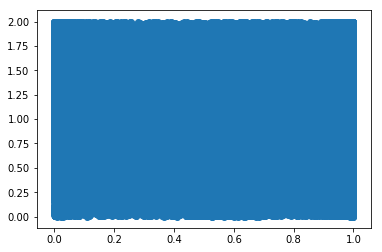

In [33]:
data_X = sess.run(class_out_single, feed_dict = {data_in: data_train, nuisances_in: nuisances_train})
data_Y = sess.run(nuisances_in, feed_dict = {data_in: data_train, nuisances_in: nuisances_train})
plt.scatter(data_X, data_Y)
plt.show()

In [34]:
for batch in range(EM_batches):
    sess.run(train_EM, feed_dict = {data_in: data_train, nuisances_in: nuisances_train})
    EM_dist_val = sess.run(EM_dist, feed_dict = {data_in: data_train, nuisances_in: nuisances_train})
    
    print("EM_dist = {}".format(EM_dist_val))

EM_dist = [0.00046879]
EM_dist = [0.0029034]
EM_dist = [0.00865757]
EM_dist = [0.00717309]
EM_dist = [0.01042414]
EM_dist = [0.00903457]
EM_dist = [0.01203233]
EM_dist = [0.0083074]
EM_dist = [0.01218265]
EM_dist = [0.00981647]
EM_dist = [0.01288843]
EM_dist = [0.00825813]
EM_dist = [0.01134443]
EM_dist = [0.00814304]
EM_dist = [0.01107836]
EM_dist = [0.00850827]
EM_dist = [0.01151901]
EM_dist = [0.00640029]
EM_dist = [0.01063532]
EM_dist = [0.00574332]
EM_dist = [0.00972033]
EM_dist = [0.00501525]
EM_dist = [0.00862563]
EM_dist = [0.00389206]
EM_dist = [0.00712502]
EM_dist = [0.00370443]
EM_dist = [0.00721657]
EM_dist = [0.00363469]
EM_dist = [0.00669146]
EM_dist = [0.00374824]
EM_dist = [0.00557578]
EM_dist = [0.00307971]
EM_dist = [0.00654936]
EM_dist = [0.00346386]
EM_dist = [0.00573099]
EM_dist = [0.00346386]
EM_dist = [0.00555778]
EM_dist = [0.00240916]
EM_dist = [0.00481248]
EM_dist = [0.00310922]
EM_dist = [0.00500381]
EM_dist = [0.00224185]
EM_dist = [0.00444973]
EM_dist = [0.

In [32]:
for epoch in range(number_epochs):
    print("epoch {}".format(epoch))

    #for epoch_EM in range(20):
    #    sess.run(train_EM, feed_dict = {data_in: data_train, nuisances_in: nuisances_train})
    
    for batch in range(number_batches):
        inds = np.random.choice(len(data_train), batch_size)
        data_batch = data_train[inds]
        labels_batch = labels_train[inds]
        nuisances_batch = nuisances_train[inds]

        sess.run(train_classifier, feed_dict = {data_in: data_batch, nuisances_in: nuisances_batch, labels_in: labels_batch})
    
        if not batch % 1000:
            EM_dist_val = sess.run(EM_dist, feed_dict = {data_in: data_train, nuisances_in: nuisances_train})
            class_loss = sess.run(classification_loss, feed_dict = {data_in: data_train, nuisances_in: nuisances_train, labels_in: labels_train})
            
            print("EM_dist = {}, class_loss = {}".format(EM_dist_val, class_loss))

epoch 0
EM_dist = [0.00072059], class_loss = 0.7107006311416626
epoch 1
EM_dist = [0.00069515], class_loss = 0.6659150123596191
epoch 2
EM_dist = [0.00073905], class_loss = 0.6554555296897888
epoch 3
EM_dist = [0.00115566], class_loss = 0.641711950302124
epoch 4
EM_dist = [-2.0749867e-05], class_loss = 0.6080396771430969
epoch 5
EM_dist = [-0.00036281], class_loss = 0.5990521311759949
epoch 6
EM_dist = [-0.00099085], class_loss = 0.5947334170341492
epoch 7
EM_dist = [-0.0010418], class_loss = 0.5932551026344299
epoch 8
EM_dist = [-0.00128306], class_loss = 0.591707706451416
epoch 9
EM_dist = [-0.00130179], class_loss = 0.5908865332603455
epoch 10
EM_dist = [-0.00147161], class_loss = 0.5918871760368347
epoch 11
EM_dist = [-0.00143285], class_loss = 0.5901516675949097
epoch 12
EM_dist = [-0.00150973], class_loss = 0.5907160639762878
epoch 13
EM_dist = [-0.00123955], class_loss = 0.5911017060279846
epoch 14
EM_dist = [-0.00136029], class_loss = 0.5895605087280273
epoch 15
EM_dist = [-0.0

In [25]:
data_test = np.loadtxt("data_test.txt")
nuisances_test = np.loadtxt("nuisances_test.txt")
labels_test = np.loadtxt("labels_test.txt")

In [48]:
pred = sess.run(classifier_output, feed_dict = {data_in: data_test})

/usr/lib/python3/dist-packages/ipykernel/__main__.py:3: MatplotlibDeprecationWarning: The griddata function was deprecated in Matplotlib 2.2 and will be removed in 3.1. Use scipy.interpolate.griddata instead.
  app.launch_new_instance()
/home/philipp/.local/lib/python3.5/site-packages/matplotlib/contour.py:1000: UserWarning: The following kwargs were not used by contour: 'interp'
  s)


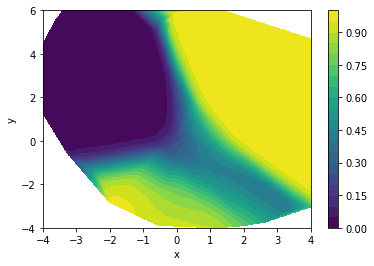

In [49]:
xi = np.linspace(-4, 4, 500)
yi = np.linspace(-4, 6, 500)
zi = griddata(data_test[:, 0], data_test[:, 1], pred[:, 0], xi, yi, interp = "linear")

plt.contourf(xi, yi, zi, interp='linear', levels = 20)
plt.xlabel('x')
plt.ylabel('y')
plt.colorbar()
plt.show()

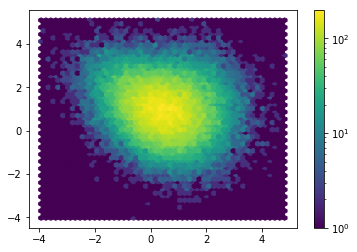

In [73]:
plt.hexbin(x = data_train[:, 0], y = data_train[:, 1], bins = 'log', gridsize = 50)
plt.colorbar()
plt.show()

In [67]:
group1 = np.logical_and(nuisances_test > 0.0, nuisances_test < 0.5)
group2 = np.logical_and(nuisances_test > 0.5, nuisances_test < 1.0)
group3 = np.logical_and(nuisances_test > 1.0, nuisances_test < 1.5)
group4 = np.logical_and(nuisances_test > 1.5, nuisances_test < 2.0)

In [68]:
pred1 = sess.run(classifier_output, feed_dict = {data_in: data_test[group1]})
pred2 = sess.run(classifier_output, feed_dict = {data_in: data_test[group2]})
pred3 = sess.run(classifier_output, feed_dict = {data_in: data_test[group3]})
pred4 = sess.run(classifier_output, feed_dict = {data_in: data_test[group4]})

In [82]:
colors = ['red', 'tan', 'lime', 'green']
plt.hist([pred1[:,1], pred2[:,1], pred3[:,1], pred4[:,1]], label = [r'$\nu_1$', r'$\nu_2$', r'$\nu_3$', r'$\nu_4$'], histtype = 'step', density = True, stacked = False, fill = False, bins = 40)
plt.legend(loc = 'upper left')
plt.savefig("pivoting_classifier_MINE.pdf")
#plt.show()

In [70]:
sig = data_test[labels_test == 1]
bkg = data_test[labels_test == 0]

In [71]:
pred_sig = sess.run(classifier_output, feed_dict = {data_in: sig})
pred_bkg = sess.run(classifier_output, feed_dict = {data_in: bkg})

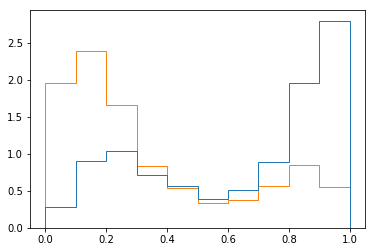

In [72]:
plt.hist([pred_sig[:,1], pred_bkg[:,1]], label = ['sig', 'bkg'], histtype = 'step', density = True, stacked = False, fill = False, bins = 10)
plt.show()

In [32]:
pred = sess.run(classifier_output, feed_dict = {data_in: data_test})

In [33]:
# plot ROC curves
from sklearn import metrics

In [34]:
fpr, tpr, thresholds = metrics.roc_curve(labels_test, pred[:,1])

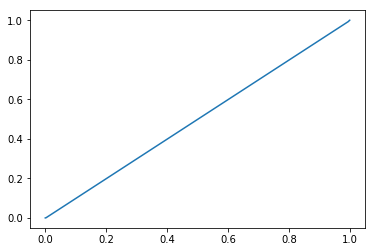

In [35]:
plt.plot(fpr, tpr)
plt.show()

In [76]:
metrics.roc_auc_score(labels_test, pred[:,1])

0.7634828323856084

In [77]:
# and load back the values of the (exact) ML estimator evaluated on them
LL_pred = np.loadtxt("LL_evaluated.csv")

In [78]:
fpr_LL, tpr_LL, thresholds_LL = metrics.roc_curve(labels_test, LL_pred)

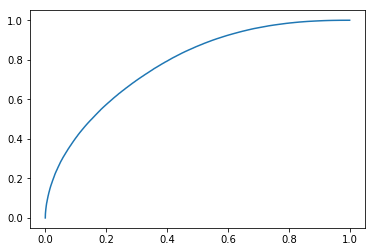

In [79]:
plt.plot(fpr_LL, tpr_LL)
plt.show()

In [80]:
metrics.roc_auc_score(labels_test, LL_pred)

0.7783846885778357

In [88]:
# plot both of them into the same graph
fig, ax = plt.subplots()
ax.plot(fpr, tpr, label = 'MI-regularized classifier', c = 'red')
ax.plot(fpr_LL, tpr_LL, label = 'analytic likelihood', c = 'black', ls = 'dashed')
leg = ax.legend(loc = 'lower right')
plt.xlabel("false positive rate")
plt.ylabel("true positive rate")
plt.show()
#plt.savefig("MI_regularized_ROC.pdf")